In [10]:
%reload_ext autoreload
%autoreload 2

import os
import io
import pickle
import sys
import time
import json
import datetime

import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.tuner import (
    ContinuousParameter,
    IntegerParameter,
    CategoricalParameter,
    HyperparameterTuner,
)
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
from tqdm import tqdm

import numpy as np
import polars as pl
from hydra import compose, initialize, core
from omegaconf import OmegaConf

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Nopep8
import tensorflow as tf

import matplotlib.pyplot as plt

## Hydra

In [38]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base="1.2", config_path="../src/config", job_name="gru_notebook")
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)

## S3

In [3]:
raw_data_path = f's3://{config["s3_bucket"]}/{config["s3_key"]}/raw-data'

train_data_path = {"train": f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data'}
train_data_path

{'train': 's3://yang-ml-sagemaker/micro-business-forecast/input-data'}

## SageMaker

In [4]:
sagemaker_session = sagemaker.Session(default_bucket=config["s3_bucket"])
sm_boto3 = boto3.client("sagemaker")
ecr_boto3 = boto3.client("ecr")
role = sagemaker.get_execution_role()

## Processing Job

We're preprocessing data from the `raw-data` s3 URI. Here's a breakdown of the steps and their rationale:

1. **Adjusting Microbusiness Density**:
   - **What**: Calculate microbusiness density as the count of microbusinesses for every 100 individuals over 18.
   - **Why**: This provides a normalized measure across counties.
   - **How**: For the training data years (2019-2022), adjust the microbusiness density by using the ratio of population estimates between a given year minus 2 and 2021. For example, 2019's density data would be adjusted using the ratio of population estimates between 2017 and 2021. For 2020, the density data would be adjusted using the ratio of population estiamtes between 2018 and 2021. And so on.
   
2. **Data Grouping**:
   - **What**: Segment counties based on their 2021 population estimates.
   - **Why**: Focusing on larger populations is critical as they show significant variance in month-over-month microbusiness density changes. The bottom 10% of counties typically show stable densities, making them less relevant for our predictive modeling. Furthermore, extremely high values (outliers) can skew predictions.
   - **How**: Divide counties into two categories: 
     1. Those above the 10th quantile of 2021 population estimates.
     2. Those below or equal to the 10th quantile. Exclude outliers with density values over 50.
     
3. **Segmenting Time Series**:
   - **What**: Use a subsection of the 41-month data for each county (specifically, Feb 2020 - Dec 2022, or 35 months) and break this into 18 separate time series of 18 months each.
   - **Why**: Segmenting data allows for more granular training, and predicting shorter intervals is often more accurate. The 13-month training and 5-month prediction windows are inspired by [Chris Deotte's Kaggle wining solution](https://www.kaggle.com/code/cdeotte/gru-model-3rd-place-gold#Kaggle-GoDaddy-Competition---3rd-Place-Gold). 
   - **Adjustability**: The `num_predictions` and `series_len` in the yaml configuration can be modified based on requirements.
     
4. **Density-to-Ratio Conversion**:
   - **What**: Transform raw microbusiness densities into monthly growth ratios.
   - **Why**: Training models on growth ratios can yield better predictive performance than using raw values. Ratios highlight the changes more directly.
   - **How**: Each month's density is divided by the previous month's density. As a result, for each `x` months of original density data, we'll have `x - 1` months of ratio data.

### Output Files

1. **train.csv**:
   - **Contents**: This file will store the micro-business density ratios derived during preprocessing.
   - **Purpose**: These ratios will serve as the primary dataset for training our models. By working with ratios instead of raw densities, we can better focus on the growth pattern and changes in micro-business density, allowing our models to make more informed predictions.

2. **densities_train_forecast.npy**:
   - **Contents**: This numpy file holds the unaltered densities for the last `x` months before the data is segmented into the 18 time series for each county (as described in step 3).
   - **Purpose**: These densities are pivotal because they form the foundation for our forecasting model. By converting these densities into ratios, we provide our models with a normalized form of the data. The models will then forecast the (**out-of-sample**) next five months' values based on these ratios.

3. **densities_target.npy**:
   - **Contents**: This numpy file houses the target raw densities, i.e., the true values that our models will aim to predict.
   - **Purpose**: A few key reasons highlight its significance:
     - **Cross-Validation Strategy**: We utilize the GroupKFold cross-validation approach. This method ensures that each unique cfips (county identifiers) appears in the validation set exactly once across all folds, ensuring an equitable distribution and validation.
     - **Out-of-Fold Predictions**: With the above strategy, our out-of-fold predictions will encompass all the cfips in the training data. This full partitioning is crucial for ensuring we have a well-rounded prediction set.
     - **Accuracy Metric Calculation**: After model predictions, we'll need to revert from ratios back to raw densities for comparison. This file provides the true values against which these converted predictions will be measured. Specifically, it helps in computing the Symmetric Mean Absolute Percentage Error (SMAPE), a metric that will assess the quality of our model's forecasts.

### Docker Image for Preprocessing

A bash script assists in building and pushing custom images to ECR. It needs:

- Docker image tag
- Mode ('preproccess' or 'serving')
- ECR repository name

In [ ]:
!cd {config['root_dir_path']} && bash ./docker/build_and_push.sh latest preprocess {config['gru']['ecr_repository']}

Construct the preprocess job image uri:

In [21]:
preprocess_images = !aws ecr list-images --repository-name {config['gru']['ecr_repository']}
preprocess_images_str = "\n".join(preprocess_images)
preprocess_images_str = json.loads(preprocess_images_str)

image_tag = preprocess_images_str["imageIds"][0]["imageTag"]

preprocess_image_uri = f"{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config['gru']['ecr_repository']}:{image_tag}"

Test processing job locally:

In [22]:
# Clear tmp directory in case we run out of space
!sudo rm -rf /tmp/tmp*

In [23]:
test_processor = Processor(
    image_uri=preprocess_image_uri,
    role=role,
    instance_type="local",
    instance_count=config["gru"]["instance_count"],
    base_job_name=config["gru"]["preprocess_base_job_name"],
    sagemaker_session=sagemaker_session,
    entrypoint=["python3", "preprocess_entry.py"],
)

test_processor.run(
    inputs=[
        ProcessingInput(
            source=raw_data_path,
            # Preprocess script expects the raw data to be in this directory
            destination=config["processing_job_input"],
        )
    ],
    outputs=[
        ProcessingOutput(
            source=config["processing_job_output"],
            # Processing job will upload the preprocessed data to this S3 uri
            destination=train_data_path["train"],
        )
    ],
    # Run in test mode to not upload the preprocessed data to S3
    arguments=["--test_mode"],
)

INFO:sagemaker:Creating processing-job with name gru-preprocess-2023-08-27-05-11-49-891
INFO:sagemaker.local.local_session:Starting processing job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-u5m57:
    container_name: vu4ylh6w1w-algo-1-u5m57
    entrypoint:
    - python3
    - preprocess_entry.py
    - --test_mode
    environment: []
    image: 722696965592.dkr.ecr.us-east-1.amazonaws.com/ml-sagemaker:latest
    networks:
      sagemaker-local:
        aliases:
        - algo-1-u5m57
    stdin_open: true
    tty: true
    volumes:
    - /tmp/tmpp6d0rqxk/algo-1-u5m57/config:/opt/ml/config
    - /tmp/tmpp6

Creating vu4ylh6w1w-algo-1-u5m57 ... 
Attaching to vu4ylh6w1w-algo-1-u5m572mdone
vu4ylh6w1w-algo-1-u5m57 | Ingesting training data...
vu4ylh6w1w-algo-1-u5m57 | Preprocessing training data...
vu4ylh6w1w-algo-1-u5m57 | Adjusting microbusiness density with new census data...
vu4ylh6w1w-algo-1-u5m57 | Splitting counties into large and small groups...
vu4ylh6w1w-algo-1-u5m57 | Converting training data to numpy arrays...
vu4ylh6w1w-algo-1-u5m57 | Converting training data to ratios...
vu4ylh6w1w-algo-1-u5m57 | Saving training data to output directory...
vu4ylh6w1w-algo-1-u5m57 | Saving last 13 months of raw densities to disk for predictions...
vu4ylh6w1w-algo-1-u5m57 | Preprocessing completed successfully!
vu4ylh6w1w-algo-1-u5m57 exited with code 0
Aborting on container exit...
===== Job Complete =====


Run the processing job:

In [24]:
processor = Processor(
    image_uri=preprocess_image_uri,
    role=role,
    instance_type=config["gru"]["preprocess_instance_type"],
    instance_count=config["gru"]["instance_count"],
    base_job_name=config["gru"]["preprocess_base_job_name"],
    sagemaker_session=sagemaker_session,
    entrypoint=["python3", "preprocess_entry.py"],
)

processor.run(
    inputs=[
        ProcessingInput(
            source=raw_data_path,
            # Preprocess script expects the raw data to be in this directory
            destination=config["processing_job_input"],
        )
    ],
    outputs=[
        ProcessingOutput(
            source=config["processing_job_output"],
            # Processing job will upload the preprocessed data to this S3 uri
            destination=train_data_path["train"],
        )
    ],
)

INFO:sagemaker:Creating processing-job with name gru-preprocess-2023-08-27-05-12-28-587


.......................Ingesting training data...
Preprocessing training data...
Adjusting microbusiness density with new census data...
Splitting counties into large and small groups...
Converting training data to numpy arrays...
Converting training data to ratios...
Saving training data to output directory...
Saving last 13 months of raw densities to disk for predictions...
Preprocessing completed successfully!



Check that the processed data has indeed been uploaded to s3:

In [25]:
sagemaker.s3.S3Downloader.list(train_data_path["train"])

['s3://yang-ml-sagemaker/micro-business-forecast/input-data/densities_target.npy',
 's3://yang-ml-sagemaker/micro-business-forecast/input-data/densities_train_forecast.npy',
 's3://yang-ml-sagemaker/micro-business-forecast/input-data/train.csv']

### Training Data Visualization

We download the data from s3 and create some visualizations of the training data:

In [26]:
train_data = pl.read_csv(os.path.join(train_data_path["train"], "train.csv"))
train_data.head(5)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


baseline_raw_density,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,y0,y1,y2,y3,y4,cfips
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
2.947928,1.008217,1.02282,1.001594,1.004773,1.021378,1.029457,1.009789,0.996271,0.951347,0.988198,0.98965,1.053902,1.012214,1.025641,1.000735,0.99853,0.996321,1001
2.983933,1.02282,1.001594,1.004773,1.021378,1.029457,1.009789,0.996271,0.951347,0.988198,0.98965,1.053902,1.012214,1.025641,1.000735,0.99853,0.996321,1.002954,1001
3.060444,1.001594,1.004773,1.021378,1.029457,1.009789,0.996271,0.951347,0.988198,0.98965,1.053902,1.012214,1.025641,1.000735,0.99853,0.996321,1.002954,0.989691,1001
3.062694,1.004773,1.021378,1.029457,1.009789,0.996271,0.951347,0.988198,0.98965,1.053902,1.012214,1.025641,1.000735,0.99853,0.996321,1.002954,0.989691,1.005208,1001
3.058193,1.021378,1.029457,1.009789,0.996271,0.951347,0.988198,0.98965,1.053902,1.012214,1.025641,1.000735,0.99853,0.996321,1.002954,0.989691,1.005208,0.99926,1001


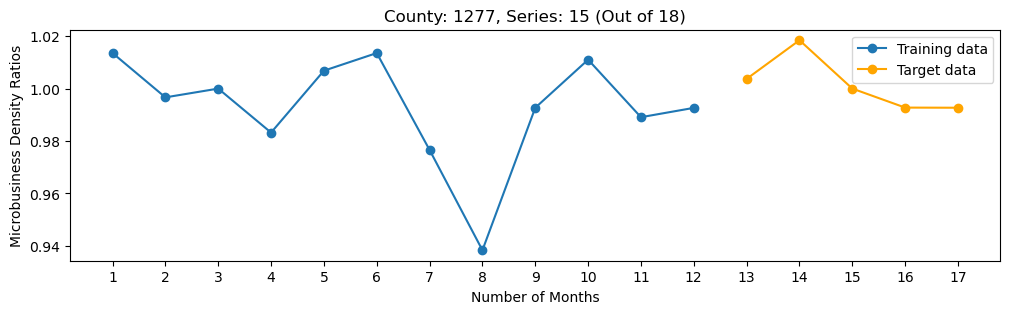

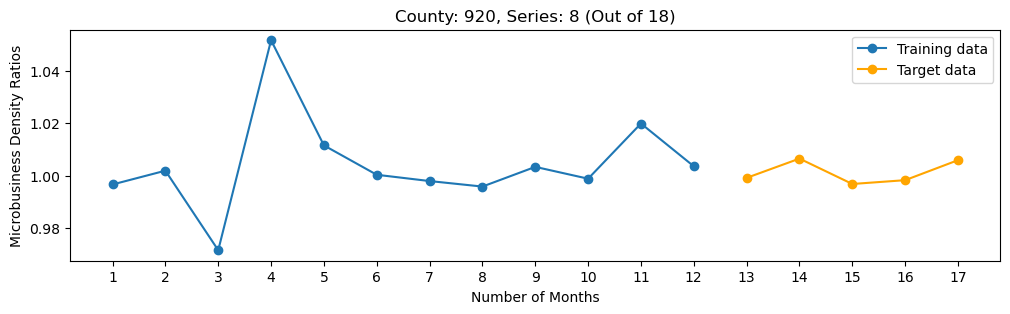

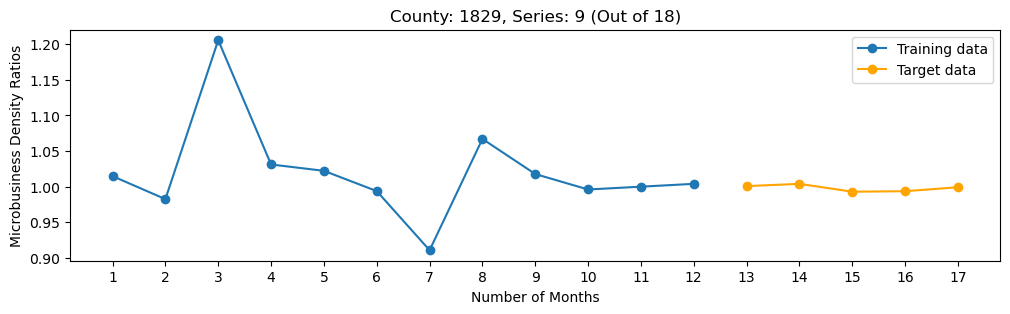

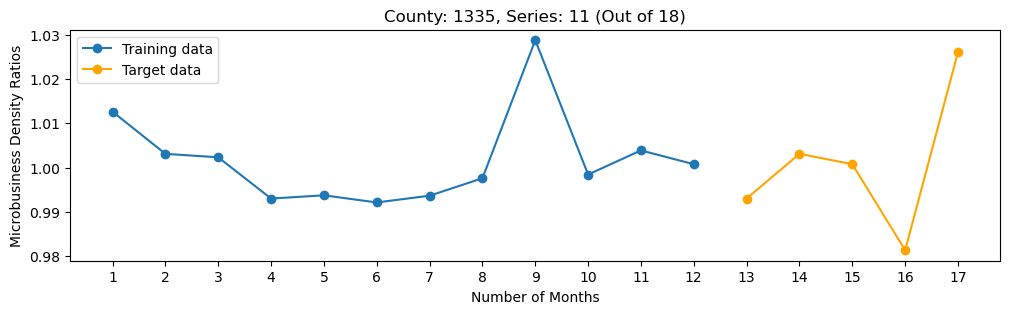

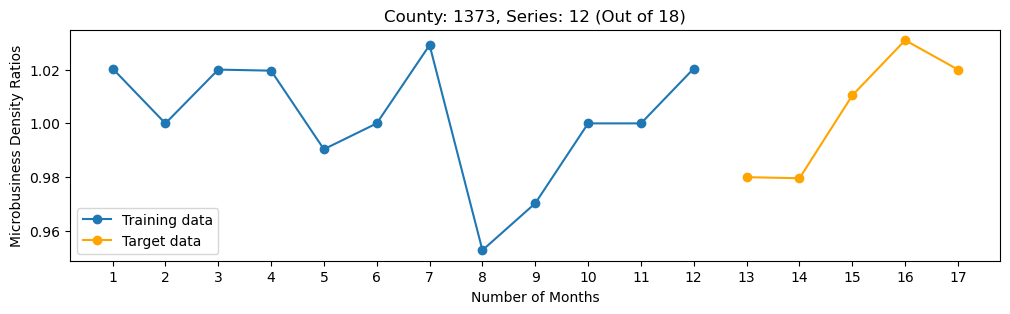

In [27]:
X_train = train_data.select(
    [col for col in train_data.columns if col.startswith("x")]
).to_numpy()
y_train = train_data.select(
    [col for col in train_data.columns if col.startswith("y")]
).to_numpy()

for i in range(5):
    # Determine which time series to plot and which county it belows to
    j = np.random.randint(0, train_data.shape[0])
    cfip = j // config["gru"]["series_len"]
    series_idx = j % config["gru"]["series_len"]

    plt.figure(figsize=(12, 3))
    # X intervals for training data
    x_interval_train = np.arange(X_train.shape[1]) + 1
    plt.plot(x_interval_train, X_train[j], "-o", label="Training data")
    # X intervals for target data
    x_interval_target = (
        np.arange(X_train.shape[1], X_train.shape[1] + y_train.shape[1]) + 1
    )
    plt.plot(x_interval_target, y_train[j], "-o", color="orange", label="Target data")

    plt.xticks(np.arange(1, X_train.shape[1] + y_train.shape[1] + 1))

    plt.title(
        f'County: {cfip}, Series: {series_idx} (Out of {config["gru"]["series_len"]})',
        size=12,
    )
    plt.xlabel("Number of Months")
    plt.ylabel("Microbusiness Density Ratios")
    plt.legend()
    plt.show()

## Tensorflow

Test training script locally:

In [5]:
!sudo rm -rf /tmp/tmp*

In [6]:
testing_estimator = TensorFlow(
    # Entry point
    entry_point=config["gru"]["entry_point"],
    source_dir=config["src_dir_path"],
    py_version=config["py_version"],
    framework_version=config["framework_version"],
    # Sagemaker
    role=role,
    instance_type="local",
    instance_count=config["gru"]["instance_count"],
    model_dir=config["model_dir"],
    code_location=config["code_location"],
    output_path=config["output_path"],
    volume_size=config["volume_size"],
    hyperparameters={
        # Architecture hyperparameters
        "gru_units_0": 8,
        "gru_units_1": 8,
        "gru_units_2": 8,
        "gru_units_3": 8,
        "gru_num_layers": 1,
        "gru_kernel_l2_factor": 0.01,
        "gru_recurrent_l2_factor": 0.01,
        "gru_dropout": 0.2,
        "gru_recurrent_dropout": 0.2,
        # Optimization and fit hyperparameters
        "adam_initial_lr": 0.001,
        "adam_beta_1": 0.9,
        "adam_beta_2": 0.999,
        "adam_epsilon": 1e-07,
        "adam_clipnorm": 1.0,
        "fit_batch_size": 4,
        "fit_epochs": 1,
        "fit_sample_weights_window_size": 3,
        # Local mode
        "test_mode": 1,
    },
)

testing_estimator.fit(train_data_path)

NOTEBOOK_METADATA_FILE detected but failed to get valid domain and user from it.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-09-09-03-33-18-574
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-wf604:
    command: train
    container_name: 694zvpggho-algo-1-wf604
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.13.0-cpu-py310
    networks:
      sagemaker-local:
        aliases:
        - algo-1-wf604
    stdin_open: true
    tt

Login Succeeded


INFO:sagemaker.local.image:image pulled: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-training:2.13.0-cpu-py310


Creating 694zvpggho-algo-1-wf604 ... 
Attaching to 694zvpggho-algo-1-wf6042mdone
694zvpggho-algo-1-wf604 | 2023-09-09 03:35:50.548042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
694zvpggho-algo-1-wf604 | To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.
694zvpggho-algo-1-wf604 | 2023-09-09 03:35:53,095 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
694zvpggho-algo-1-wf604 | 2023-09-09 03:35:53,097 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
694zvpggho-algo-1-wf604 | 2023-09-09 03:35:53,098 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
694zvpggho-algo-1-wf604 | 2023-09-09 03:35:53,108 sagemaker-training-toolkit INFO     instance_groups entry not present in resource_config


INFO:root:creating /tmp/tmprckvx6g_/artifacts/output/data
INFO:root:copying /tmp/tmprckvx6g_/algo-1-wf604/output/success -> /tmp/tmprckvx6g_/artifacts/output
INFO:root:copying /tmp/tmprckvx6g_/model/fold_1_model.keras -> /tmp/tmprckvx6g_/artifacts/model
INFO:root:copying /tmp/tmprckvx6g_/model/fold_2_model.keras -> /tmp/tmprckvx6g_/artifacts/model


694zvpggho-algo-1-wf604 exited with code 0
Aborting on container exit...
===== Job Complete =====


### Hyperparameter Optimization

Re-instantiate the estimator:

In [ ]:
gru_estimator = TensorFlow(
    # Entry point
    entry_point=config["gru"]["entry_point"],
    source_dir=config["src_dir_path"],
    py_version=config["py_version"],
    framework_version=config["framework_version"],
    # Sagemaker
    role=role,
    instance_type=config["gru"]["instance_type"],
    instance_count=config["gru"]["instance_count"],
    model_dir=config["model_dir"],
    code_location=config["code_location"],
    output_path=config["output_path"],
    volume_size=config["volume_size"],
    # Spot training
    max_run=config["max_run"],
    max_wait=config["max_run"],  # Equal or greater than max_run
    max_retry_attempts=config["max_retry_attempts"],
    use_spot_instances=config["use_spot_instances"],
    checkpoint_s3_uri=os.path.join(config["checkpoint_s3_uri"], "gru"),
    hyperparameters={"test_mode": 0},
)
gru_estimator

Define search space and metric (SMAPE) to optimize:

In [39]:
gru_search_space = {
    # Architecture hyperparameters
    "gru_units_0": CategoricalParameter(values=[8, 16]),
    "gru_units_1": CategoricalParameter(values=[8, 16]),
    "gru_units_2": CategoricalParameter(values=[8, 16]),
    "gru_units_3": CategoricalParameter(values=[8, 16]),
    "gru_num_layers": IntegerParameter(min_value=2, max_value=4),
    "gru_kernel_l2_factor": ContinuousParameter(min_value=1e-5, max_value=1e-1),
    "gru_recurrent_l2_factor": ContinuousParameter(min_value=1e-5, max_value=1e-1),
    "gru_dropout": ContinuousParameter(min_value=0.1, max_value=0.5),
    "gru_recurrent_dropout": ContinuousParameter(min_value=0.1, max_value=0.5),
    # Optimization and fit hyperparameters
    "adam_initial_lr": ContinuousParameter(min_value=1e-4, max_value=1e-1),
    "adam_beta_1": ContinuousParameter(min_value=0.7, max_value=0.999),
    "adam_beta_2": ContinuousParameter(min_value=0.7, max_value=0.999),
    "adam_epsilon": ContinuousParameter(min_value=1e-7, max_value=1e-1),
    "adam_clipnorm": ContinuousParameter(min_value=1e-2, max_value=2.0),
    "fit_batch_size": IntegerParameter(min_value=4, max_value=16),
    "fit_epochs": IntegerParameter(min_value=2, max_value=3),
    "fit_sample_weights_window_size": IntegerParameter(min_value=1, max_value=3),
}

gru_objective_metric_name = "smape"
gru_objective_type = "Minimize"
gru_metric_definitions = [
    {
        "Name": gru_objective_metric_name,
        "Regex": "Best validation SMAPE over all folds: ([0-9\\.]+)",
    }
]

Hyperparameter tuning:

In [40]:
gru_hpo_tuner = HyperparameterTuner(
    estimator=gru_estimator,
    objective_metric_name=gru_objective_metric_name,
    hyperparameter_ranges=gru_search_space,
    metric_definitions=gru_metric_definitions,
    strategy="Bayesian",
    objective_type=gru_objective_type,
    max_jobs=5,
    max_parallel_jobs=5,
    base_tuning_job_name=config["gru"]["base_tuning_job_name"],
)

In [41]:
gru_hpo_tuner.fit(train_data_path)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [43]:
gru_hpo_analytics = sagemaker.HyperparameterTuningJobAnalytics(
    gru_hpo_tuner.latest_tuning_job.name
)

gru_hpo_results = gru_hpo_analytics.dataframe()

gru_hpo_results.sort_values("FinalObjectiveValue", ascending=True)

,adam_beta_1,adam_beta_2,adam_clipnorm,adam_epsilon,adam_initial_lr,fit_batch_size,fit_epochs,fit_sample_weights_window_size,gru_dropout,gru_kernel_l2_factor,...,gru_units_0,gru_units_1,gru_units_2,gru_units_3,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,0.994181,0.995177,0.012331,0.000121,0.001358,13.0,3.0,3.0,0.382040,0.000013,...,"""8""","""16""","""16""","""16""",gru-hpo-230909-0456-005-21c9f913,Completed,8.012546,2023-09-09 04:58:32+00:00,2023-09-09 07:12:28+00:00,8036.0
0,0.775610,0.956679,0.039703,0.001050,0.004605,6.0,2.0,3.0,0.179631,0.016858,...,"""8""","""16""","""8""","""16""",gru-hpo-230909-0456-006-d04a32e8,Completed,8.013266,2023-09-09 05:09:44+00:00,2023-09-09 07:13:33+00:00,7429.0
3,0.983176,0.960341,0.611246,0.095204,0.082828,12.0,2.0,3.0,0.454326,0.012003,...,"""16""","""16""","""8""","""16""",gru-hpo-230909-0456-003-72abd2cf,Completed,8.016558,2023-09-09 04:58:22+00:00,2023-09-09 05:57:00+00:00,3518.0
4,0.976440,0.995499,1.062575,0.013031,0.073596,7.0,2.0,3.0,0.418138,0.000107,...,"""16""","""16""","""8""","""16""",gru-hpo-230909-0456-002-bab6ee35,Completed,8.016614,2023-09-09 04:58:16+00:00,2023-09-09 07:46:17+00:00,10081.0
2,0.986856,0.889460,0.089468,0.030456,0.001264,14.0,3.0,1.0,0.240499,0.005701,...,"""8""","""8""","""16""","""16""",gru-hpo-230909-0456-004-462331ec,Completed,8.410225,2023-09-09 04:58:38+00:00,2023-09-09 06:10:52+00:00,4334.0
